<font color='green' size='7'>**Итоговая работа**</font>  
<font color='#11a642' size='6'>**Тема: Машинное обучение**</font>  
<font size='5'>**Задание:**</font>  

Задание
Рекомендуем исследование оформлять в jupiter notebook с текстовыми пояснениями и выводами (маркдаунами). Код без комментариев и выводов не принимается к защите.
1. Для проведения исследования требуется выбрать данные, которые не содержат персональных характеристик реальных людей. Рекомендуем выбирать данные из наборов, доступных на Kaggle или других источниках данных. Использование выбранного набора данных необходимо согласовать с вашим наставником.
2. Проведение разведочного анализа данных (EDA)

    a. Необходимо рассчитать статистики (например, медиана, дисперсия,
квантили и так далее)

    b. Построить полезные графики

    c. Сделать выводы

3. Предобработка данных.

    a. Если в данных есть пропущенные значения, необходимо их обработать

    b. Если в данных есть выбросы, необходимо их обработать

    c. Если в данных есть категориальные значения, необходимо их обработать

    d. Если признаков очень много, воспользуетесь методами понижения размерности (например, РСА)
4. Проверка статистических гипотез.

    a. Необходимо сформулировать на данных минимум 2 гипотезы и проверить их с помощью статистических критериев
    
5. Построение моделей машинного обучения. Необходимо построить минимум 5 моделей машинного обучения с использованием следующих алгоритмов (необходимо использовать разные алгоритмы)
    *   Линейная регрессия
    *   Метод knn
    *  Дерево решений
    *  Random forest
    *  Градиентный бустинг (можно любой фреймворк, либо sklearn, xgboost,
lightgbm, catboost)
6. Сравнить полученные модели с помощью метрик качества. Выбрать лучшую модель. Сделать выводы. Выгрузить лучшую модель из блокнота jupiter (например, с помощью библиотеки joblib или pickle).

7. Описать как планируется использовать модель после выгрузки. Создать еще один блокнот jupiter (или код на языке python в файле *.py) и загрузить модель для использования (например, с помощью библиотеки joblib). Должна быть реализована следующая логика:
    * Пользователь вводит данные
    * Далее запускаем ячейку в jupiter notebook или запускаем файл *.py
    * Получаем ответ модели и рекомендации
Дополнительно. Возможна реализация использования модели не в jupiter notebook или файле python *.py, а с применением библиотеки Streamlit (или аналогичных).





In [6]:
%pip install catboost
%pip install keras_tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.5 MB/s eta 0:00:00


# <font color='#11a642' size='6'> **Импорт и установка библиотек**

In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sb

from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OneHotEncoder


import sklearn.linear_model as skl
import sklearn.metrics as skm
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import get_scorer_names
import sklearn.preprocessing as spre
import sklearn.model_selection as sm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.calibration import calibration_curve, CalibrationDisplay

# CVC
from sklearn.svm import SVC
from sklearn.inspection import permutation_importance

# KNN
from sklearn.neighbors import KNeighborsClassifier

# XGB
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

# CatBoost
import catboost as ctb
from catboost import CatBoostClassifier
from catboost import Pool, cv

# LightGBM
import lightgbm as lgb
from lightgbm import LGBMClassifier, plot_importance

# Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.inspection import permutation_importance
import keras_tuner as kt
from keras_tuner import Hyperband
from tensorflow.keras.metrics import AUC, Precision, Recall
from sklearn.base import BaseEstimator, ClassifierMixin

/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


# Используемые функции:

In [8]:
def brief_df (df):
  # Подсчитываем пустые значения и уникальные значение
  rows_na =df.isna().sum().reset_index().rename(columns={0: "valuesNa"})
  rows_notna = df.notna().sum().reset_index().rename(columns={0: "valuesNotNa"})
  rows_analysis = pd.merge(rows_na, rows_notna, on="index", how= "outer")
  rows_analysis["completeRatio"] = round((rows_analysis["valuesNotNa"]) / (rows_analysis["valuesNotNa"]+rows_analysis["valuesNa"])*100,2)

  cardinality = df.nunique().reset_index().rename(columns={0: "cardinality"})
  rows_analysis = pd.merge(rows_analysis, cardinality)

  # Размер датасета и кол-во дубликатов
  print("Размер:", df.shape)
  dup_raw = df.duplicated ().sum()
  dup_per = round((dup_raw*100)/df.shape[0],2)
  print ("Дубликаты:", dup_raw, "-&gt;", dup_per, "%")

  # Статистика по пустым значениям
  print("Проверка на отсутсвующие значениия")
  display(rows_analysis)

  # Первые пять строк
  print("Первые пять строк")
  display(df.head())

In [9]:
def isnull_txt(df_colum):
  '''
  function fill null values
  for categorical - 'Unknown'

  params:
  df_colum - columns
  '''
  df[df_colum]=df[df_colum].fillna('Unknown')            #Замена пустых значений на 'unknown'
  df[df_colum].isnull().sum()                                   #Проверка (Подсчет количества нулевых ячеек)
  print(df[df_colum].isnull().sum())                            #вывод количества нулевых значений


In [10]:
def fam_members(x):
    if x == 1:
        x = "Один"
    elif x == 2:
        x = "Два"
    elif x == 3:
        x = "Три"
    else:
        x = "Более трех"
    return x

In [11]:
def time_category(x):
    if x < 2: # 1 год и меньше
        x = "менее года"
    elif x<6: # от 1 до 5 лет
        x = "1-5 лет"
    elif x<11: # от 5 до 10 лет
        x = "5-10 лет"
    elif x<16: # от 10 до 15 лет
        x = "10-15 лет"
    elif x<21: # от 15 до 20 лет
        x = "15-20 лет"
    else:      # более 20 лет
        x = "более 20"
    return x

In [12]:
def age_category(x):
    if x < 30:
        x = "до 30"
    elif x<40:
        x = "30-40"
    elif x<50:
        x = "40-50"
    elif x<60:
        x = "50-60"
    else:
        x = "более чем 60"
    return x

In [13]:
def work(x):
    if x in ['Security staff', 'Sales staff', 'Drivers', 'Cleaning staff', 'Private service staff', 'Cooking staff', 'Waiters/barmen staff', 'Realty agents']:
        x = "Услуги"
    elif x in ['Accountants', 'Core staff', 'Managers', 'High skill tech staff', 'Secretaries', 'HR staff', 'IT staff', 'Medicine staff']:
        x = "Офис"
    elif x in ['Laborers', 'Low-skill Laborers']:
        x = "Рабочие"
    else:
        x = "Неизвестно"
    return x


# <font color='#11a642' size='6'> **Загрузка данных**

Используется набор данных с kaggle https://www.kaggle.com/datasets/rikdifos/credit-card-approval-prediction/data.

Цель работы -  Прогноз одобрения кредитной карты

application_record.csv
1.   ID	Номер клиента
2. CODE_GENDER	Пол
3. FLAG_OWN_CAR	Есть ли машина
4. FLAG_OWN_REALTY	Есть ли недвижимость
5. CNT_CHILDREN	Количество детей
6. AMT_INCOME_TOTAL	Годовой доход
7. NAME_INCOME_TYPE	Категория дохода
8. NAME_EDUCATION_TYPE	Уровень образования
9. NAME_FAMILY_STATUS	Семейное положение
10. NAME_HOUSING_TYPE	Образ жизни
11. DAYS_BIRTH	День рождения	Считается в обратном порядке от текущего дня (0), -1 означает вчерашний день
12. DAYS_EMPLOYED	Дата начала работы.	Считается в обратном порядке от текущего дня (0). Если число положительное, то это означает, что человек в настоящее время безработный.
13. FLAG_MOBIL	Есть ли мобильный телефон?
14. FLAG_WORK_PHONE	Есть ли рабочий телефон?
15. FLAG_PHONE	Есть ли телефон?
16. FLAG_EMAIL	Есть ли электронная почта?
17. OCCUPATION_TYPE	Занятие
18. CNT_FAM_MEMBERS	Размер семьи


кредит_запись.csv


1.   ID	Номер клиента
2. MONTHS_BALANCE	Рекордный месяц. 	Месяц извлеченных данных является начальной точкой, в обратном порядке 0 — текущий месяц, -1 — предыдущий месяц и т. д.
3. STATUS	Статус
    * 0: 1-29 дней просрочки
    * 1: 30-59 дней просрочки
    * 2: 60-89 дней просрочки
    * 3: 90-119 дней просрочки
    * 4: 120-149 дней просрочки
    * 5: Просроченная или безнадежная задолженность, списанная более чем на 150 дней C: погашено в этом месяце X: За месяц кредита нет

In [14]:
#Загрузка данных
df_app = pd.read_csv("https://drive.google.com/uc?id=163Buw8xH6E_OhFaOTGvFrmPua0Ud5cv0")
df_credit = pd.read_csv("https://drive.google.com/uc?id=1iTW4qBdx7XYcnLfc6iKz630reKR9tBn9")
df_app1 = df_app.copy()
df1_credit = df_credit.copy()

# <font color='#11a642' size='6'> **Первичный анализ данных**

## <font color='#11a642' size='5'> Рассмотрение df_app

In [15]:
df_app.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


In [16]:
#Общая информация о датафрейме df_app
df_app.info()
df_app.describe().T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438557 entries, 0 to 438556
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   438557 non-null  int64  
 1   CODE_GENDER          438557 non-null  object 
 2   FLAG_OWN_CAR         438557 non-null  object 
 3   FLAG_OWN_REALTY      438557 non-null  object 
 4   CNT_CHILDREN         438557 non-null  int64  
 5   AMT_INCOME_TOTAL     438557 non-null  float64
 6   NAME_INCOME_TYPE     438557 non-null  object 
 7   NAME_EDUCATION_TYPE  438557 non-null  object 
 8   NAME_FAMILY_STATUS   438557 non-null  object 
 9   NAME_HOUSING_TYPE    438557 non-null  object 
 10  DAYS_BIRTH           438557 non-null  int64  
 11  DAYS_EMPLOYED        438557 non-null  int64  
 12  FLAG_MOBIL           438557 non-null  int64  
 13  FLAG_WORK_PHONE      438557 non-null  int64  
 14  FLAG_PHONE           438557 non-null  int64  
 15  FLAG_EMAIL       

,count,mean,std,min,25%,50%,75%,max
ID,438557.0,6.022176e+06,571637.023257,5008804.0,5609375.0,6047745.0,6456971.0,7999952.0
CNT_CHILDREN,438557.0,4.273903e-01,0.724882,0.0,0.0,0.0,1.0,19.0
AMT_INCOME_TOTAL,438557.0,1.875243e+05,110086.853066,26100.0,121500.0,160780.5,225000.0,6750000.0
DAYS_BIRTH,438557.0,-1.599790e+04,4185.030007,-25201.0,-19483.0,-15630.0,-12514.0,-7489.0
DAYS_EMPLOYED,438557.0,6.056368e+04,138767.799647,-17531.0,-3103.0,-1467.0,-371.0,365243.0
FLAG_MOBIL,438557.0,1.000000e+00,0.000000,1.0,1.0,1.0,1.0,1.0
FLAG_WORK_PHONE,438557.0,2.061328e-01,0.404527,0.0,0.0,0.0,0.0,1.0
FLAG_PHONE,438557.0,2.877710e-01,0.452724,0.0,0.0,0.0,1.0,1.0
FLAG_EMAIL,438557.0,1.082071e-01,0.310642,0.0,0.0,0.0,0.0,1.0
CNT_FAM_MEMBERS,438557.0,2.194465e+00,0.897207,1.0,2.0,2.0,3.0,20.0


In [17]:
print(f'Количество строк и столбцов: {df_app.shape}')
print(f'Датафрейм занимает: {round(df_app.memory_usage(index=True, deep=True).sum()/(1024*1024*1024),2)} ГБ')



Количество строк и столбцов: (438557, 18)
Датафрейм занимает: 0.25 ГБ


In [18]:
#Количество уникальных значений:
df_app.nunique()

,0
ID,438510
CODE_GENDER,2
FLAG_OWN_CAR,2
FLAG_OWN_REALTY,2
CNT_CHILDREN,12
AMT_INCOME_TOTAL,866
NAME_INCOME_TYPE,5
NAME_EDUCATION_TYPE,5
NAME_FAMILY_STATUS,5
NAME_HOUSING_TYPE,6


In [19]:
# Переименуем столбцы в удобный формат (нижний регистр без пробелов)
lst = df_app.columns.to_list()
column_name = []
for i in lst:
    lst_word = i.split("_" , 1)
    for j in lst_word:
        name = j.lower()
    column_name.append(name)

df_app.columns = column_name

In [20]:
df_app.head(1)

,id,gender,own_car,own_realty,children,income_total,income_type,education_type,family_status,housing_type,birth,employed,mobil,work_phone,phone,email,type,fam_members
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0


Первичный анализ данных

## <font color='#11a642' size='5'> Рассмотрение df_credit

In [21]:
df_credit.head()

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


In [22]:
#Общая информация о датафрейме df_credit
df_credit.info()
df_credit.describe().T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 3 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   ID              1048575 non-null  int64 
 1   MONTHS_BALANCE  1048575 non-null  int64 
 2   STATUS          1048575 non-null  object
dtypes: int64(2), object(1)
memory usage: 24.0+ MB


,count,mean,std,min,25%,50%,75%,max
ID,1048575.0,5.068286e+06,46150.578505,5001711.0,5023644.0,5062104.0,5113856.0,5150487.0
MONTHS_BALANCE,1048575.0,-1.913700e+01,14.023498,-60.0,-29.0,-17.0,-7.0,0.0


In [23]:
print(f'Количество строк и столбцов: {df_credit.shape}')
print(f'Датафрейм занимает: {round(df_credit.memory_usage(index=True, deep=True).sum()/(1024*1024*1024),2)} ГБ')

Количество строк и столбцов: (1048575, 3)
Датафрейм занимает: 0.07 ГБ


In [24]:
#Количество уникальных значений:
df_credit.nunique()

,0
ID,45985
MONTHS_BALANCE,61
STATUS,8


In [25]:
# Процентное соотношение категорий в данных
df_credit.groupby('STATUS')[['ID']].count()/df_credit.shape[0]

,ID
STATUS,
0,0.365372
1,0.010576
2,0.000828
3,0.000305
4,0.000213
5,0.001615
C,0.421554
X,0.199537


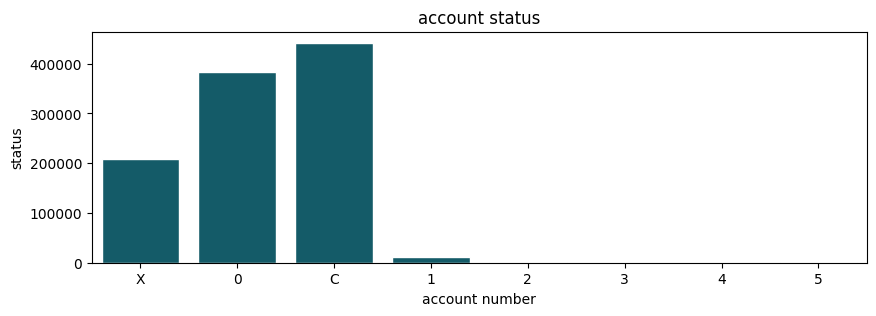

In [26]:
plt.figure(figsize = (10,3))
plt.title('account status', loc = 'center', fontsize=12)
plt.xlabel('account number', loc = 'center', fontsize=10)
plt.ylabel('status', loc = 'center', fontsize=10)
sb.set_theme(style="whitegrid")
sb.countplot(data = df_credit, x = df_credit['STATUS'], color = '#066576')
plt.show()

In [27]:
# Подсчитывается количество счетов, по которым когда-либо были просрочены платежи
# Мы будем учитывать все счета, имеющие статус 1 или более
lst = ["0", "1", "2", "3", "4", "5"]
account_num = df_credit['ID'].nunique()
bad_accounts_bystatus = []
percent_bad_accounts = []
bad_accounts = pd.DataFrame(['status', '%_bad_accounts'])
for i in range(0,6):
    df_credit.loc[:,'status>='+str(i)] = df_credit.loc[:, "STATUS"].apply(lambda x: 1 if x in lst[i:] else 0)
    bad_accounts = df_credit.groupby('ID').agg({'status>='+str(i): "max"}).sum()
    bad_accounts_bystatus.append(bad_accounts.index[0])
    percent_bad_accounts.append(bad_accounts[0]/account_num )
data = {'status' : bad_accounts_bystatus, '%_bad_accounts': percent_bad_accounts}
pd.DataFrame(data = data)

<ipython-input-27-474d9fed949a>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  percent_bad_accounts.append(bad_accounts[0]/account_num )
<ipython-input-27-474d9fed949a>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  percent_bad_accounts.append(bad_accounts[0]/account_num )
<ipython-input-27-474d9fed949a>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  percent_bad_accounts.append(bad_accounts[0]/account_num )
<ipython-input-2

,status,%_bad_accounts
0,status>=0,0.870545
1,status>=1,0.116342
2,status>=2,0.014505
3,status>=3,0.007198
4,status>=4,0.005284
5,status>=5,0.004241


Для "плохих аккаунтов" - мы отберем все аккаунты, которые находятся в staus 2 или более (1,4% от общего числа аккаунтов).

In [28]:
df_credit['account_status'] = df_credit['STATUS'].replace({ "C" : 0, "X" : 0, "0" : 0, "1" : 0, "2" : 1, "3": 1, "4": 1, "5" : 1})
bad_accounts = df_credit.groupby('ID').agg({'account_status': "max"})
bad_accounts.reset_index(inplace = True)
# Percentage by category - good/bad account
bad_accounts['account_status'].value_counts(normalize = True)

<ipython-input-28-7e094f3dc587>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_credit['account_status'] = df_credit['STATUS'].replace({ "C" : 0, "X" : 0, "0" : 0, "1" : 0, "2" : 1, "3": 1, "4": 1, "5" : 1})


,proportion
account_status,
0,0.985495
1,0.014505


In [29]:
#Вычисление столбца, который будет отражать время существования учетной записи
bad_accounts_seniority = df_credit.groupby('ID').agg({'MONTHS_BALANCE': "min"})
bad_accounts_seniority.rename(columns = {'MONTHS_BALANCE' : 'seniority'}, inplace = True)
df_credit = pd.merge(bad_accounts_seniority, bad_accounts, left_index = True, right_on = "ID")
df_credit['seniority'] = df_credit['seniority']*-1
df_credit.head(3)

,seniority,ID,account_status
0,3,5001711,0
1,18,5001712,0
2,21,5001713,0


In [30]:
#Подсчет уникальных значений относительно id
print('Уникальные значения credit:', df_credit['ID'].nunique())
print('Уникальные значения app:', df_app['id'].nunique())


Уникальные значения credit: 45985
Уникальные значения app: 438510


## <font color='#11a642' size='5'> Объединение данных (ориентироваться будем на столбец status при сборе данных в 1 таблицу):

In [31]:
# Уникальный идентификатор после объединения таблиц
df = pd.merge(df_credit, df_app, left_on = 'ID', right_on = 'id', how = 'inner')
df.drop(columns = ['ID'], inplace = True)
df.dropna(axis = 0, subset = ['account_status'],  inplace = True)
print('Уникальные значения после объединения:', df_app['id'].nunique())

Уникальные значения после объединения: 438510


## <font color='#11a642' size='5'> Рассмотрение итогового Датафрема df

In [32]:
df.head(3)

,seniority,account_status,id,gender,own_car,own_realty,children,income_total,income_type,education_type,family_status,housing_type,birth,employed,mobil,work_phone,phone,email,type,fam_members
0,15,0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,14,0,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,29,0,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0


In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36457 entries, 0 to 36456
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   seniority       36457 non-null  int64  
 1   account_status  36457 non-null  int64  
 2   id              36457 non-null  int64  
 3   gender          36457 non-null  object 
 4   own_car         36457 non-null  object 
 5   own_realty      36457 non-null  object 
 6   children        36457 non-null  int64  
 7   income_total    36457 non-null  float64
 8   income_type     36457 non-null  object 
 9   education_type  36457 non-null  object 
 10  family_status   36457 non-null  object 
 11  housing_type    36457 non-null  object 
 12  birth           36457 non-null  int64  
 13  employed        36457 non-null  int64  
 14  mobil           36457 non-null  int64  
 15  work_phone      36457 non-null  int64  
 16  phone           36457 non-null  int64  
 17  email           36457 non-null 

Рассмотрение итогового набора данных:

In [34]:
df.head(3)

,seniority,account_status,id,gender,own_car,own_realty,children,income_total,income_type,education_type,family_status,housing_type,birth,employed,mobil,work_phone,phone,email,type,fam_members
0,15,0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,14,0,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,29,0,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0


# <font color='#11a642' size='6'> **Разведочный анализ данных**

In [35]:
brief_df(df)

Размер: (36457, 20)
Дубликаты: 0 -&gt; 0.0 %
Проверка на отсутсвующие значениия


,index,valuesNa,valuesNotNa,completeRatio,cardinality
0,account_status,0,36457,100.00,2
1,birth,0,36457,100.00,7183
2,children,0,36457,100.00,9
3,education_type,0,36457,100.00,5
4,email,0,36457,100.00,2
5,employed,0,36457,100.00,3640
6,fam_members,0,36457,100.00,10
7,family_status,0,36457,100.00,5
8,gender,0,36457,100.00,2
9,housing_type,0,36457,100.00,6


Первые пять строк


,seniority,account_status,id,gender,own_car,own_realty,children,income_total,income_type,education_type,family_status,housing_type,birth,employed,mobil,work_phone,phone,email,type,fam_members
0,15,0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,14,0,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,29,0,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,4,0,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,26,0,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


## <font color='#11a642' size='5'> Анализ признаков


Перенос данных в годовые значения (на 1 меньше, чем за год или меньше и т.д.) по трудовому стажу

In [36]:
df['seniority'] = df['seniority']/11
df['seniority'] = np.ceil(df['seniority']).astype(int)

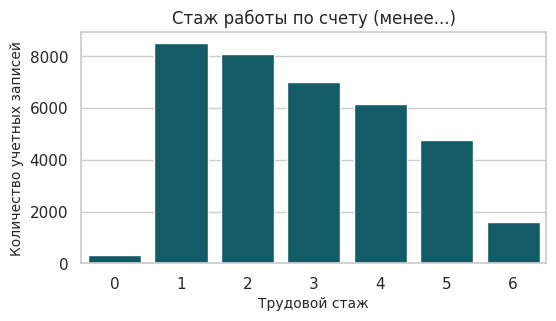

In [37]:
plt.figure(figsize = (6,3))
plt.title('Стаж работы по счету (менее...)', loc = 'center', fontsize=12)
plt.xlabel('Трудовой стаж', loc = 'center', fontsize=10)
plt.ylabel('Количество учетных записей', loc = 'center', fontsize=10)
sb.countplot(data = df, x = df['seniority'], color = '#066576')
plt.show()

Клиенты по количеству детей

In [38]:
df['children'].value_counts().sort_index()

,count
children,
0,25201
1,7492
2,3256
3,419
4,63
5,20
7,2
14,3
19,1


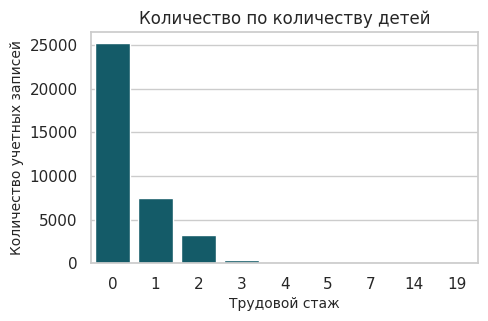

In [39]:
plt.figure(figsize = (5,3))
plt.title('Количество по количеству детей')
sb.countplot(data = df, x = df['children'], color = '#066576')
plt.xlabel('Трудовой стаж', loc = 'center', fontsize=10)
plt.ylabel('Количество учетных записей', loc = 'center', fontsize=10)
plt.show()

Переназначение определения по количеству детей
* 0 - без детей
* 1 - 1 или 2 ребенка
* 3 или более детей

In [40]:
df.loc[:, 'children']= df.loc[:,'children'].apply(lambda x: "Отсутствуют" if x == 0 else ("Один или два" if x in [1, 2] else "Более чем двое"))

<ipython-input-40-a20d55a51c5c>:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['Отсутствуют' 'Отсутствуют' 'Отсутствуют' ... 'Один или два'
 'Один или два' 'Отсутствуют']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[:, 'children']= df.loc[:,'children'].apply(lambda x: "Отсутствуют" if x == 0 else ("Один или два" if x in [1, 2] else "Более чем двое"))


In [41]:
df['children'].value_counts().sort_index()

,count
children,
Более чем двое,508
Один или два,10748
Отсутствуют,25201


Количество членов семьи

In [42]:
df['fam_members'].value_counts().sort_index()

,count
fam_members,
1.0,6987
2.0,19463
3.0,6421
4.0,3106
5.0,397
6.0,58
7.0,19
9.0,2
15.0,3


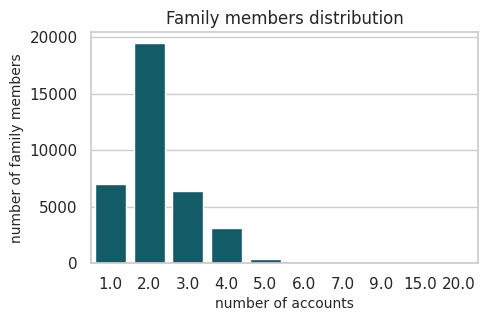

In [43]:
plt.figure(figsize = (5,3))
plt.title('Family members distribution')
sb.countplot(data = df, x = df['fam_members'], color = '#066576')
plt.xlabel('number of accounts', loc = 'center', fontsize=10)
plt.ylabel('number of family members', loc = 'center', fontsize=10)
plt.show()

Разделение на категории по составу семьи

In [44]:
df.loc[:, 'fam_members']= df.loc[:,'fam_members'].apply(fam_members)

<ipython-input-44-477170bcc595>:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['Два' 'Два' 'Два' ... 'Три' 'Три' 'Два']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[:, 'fam_members']= df.loc[:,'fam_members'].apply(fam_members)


In [45]:
df['fam_members'].value_counts()

,count
fam_members,
Два,19463
Один,6987
Три,6421
Более трех,3586


Отработанное время

In [46]:
# Перевод данных в годовые значения (на 1 меньше года или менее и т.д.)
df['time_employed'] = -df_app['employed']/365
df['time_employed'] = np.ceil(df['time_employed']).astype(int)



In [47]:
# Расчет и завершение по среднему рабочему времени для группы безработных
# Группа безработных выставляем nan
df.loc[:, 'time_employed'] = df.loc[:, 'time_employed'].apply(lambda x: np.NaN if x < 0  else x)
# Расчет среднего значения для тех, кто работает, и завершение среднего рабочего времени для безработных
df.loc[:, 'time_employed'] = df.loc[:, 'time_employed'].fillna(df['time_employed'].mean())
df['time_employed'] = df['time_employed'].astype('int')

<ipython-input-47-da03e05956fb>:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[13. 13.  4. ...  3.  3.  7.]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[:, 'time_employed'] = df.loc[:, 'time_employed'].apply(lambda x: np.NaN if x < 0  else x)


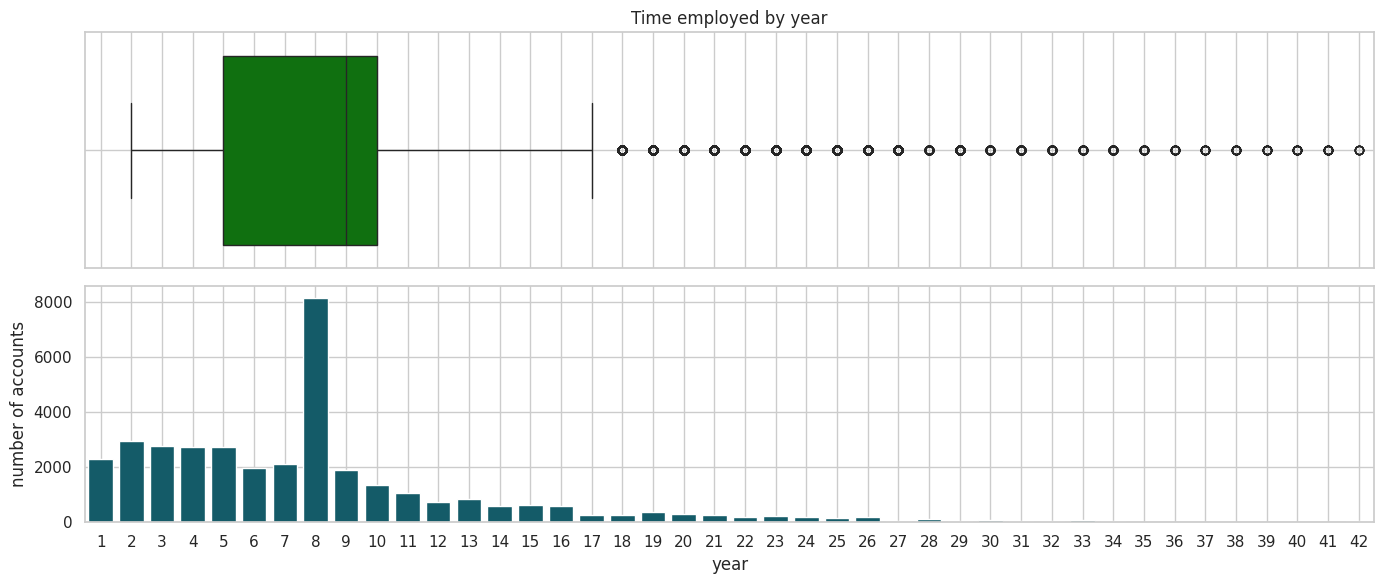

In [48]:
fig, place = plt.subplots(nrows = 2, ncols=1, figsize=(14,6), sharex=True)

sb.boxplot(data = df, x = 'time_employed', ax=place[0], color = 'green')
place[0].set_title('Time employed by year')
place[0].grid(True)

sb.countplot(data = df, x = 'time_employed', ax = place[1], color = '#066576')
place[1].set_xlabel('year', loc = 'center')
place[1].set_ylabel('number of accounts', loc = 'center')
place[1].grid(True)

plt.tight_layout()
plt.show()

In [49]:
df['time_employed'] = df['time_employed'].apply(time_category)
# Количество в категориях после перестановки
df['time_employed'].value_counts().sort_index()

,count
time_employed,
1-5 лет,11192
10-15 лет,3872
15-20 лет,1779
5-10 лет,15483
более 20,1843
менее года,2288


Перевод даты рождения в возраст

In [50]:
df['age'] = df['birth']//-365
df['age'] = df['age'].astype(int)

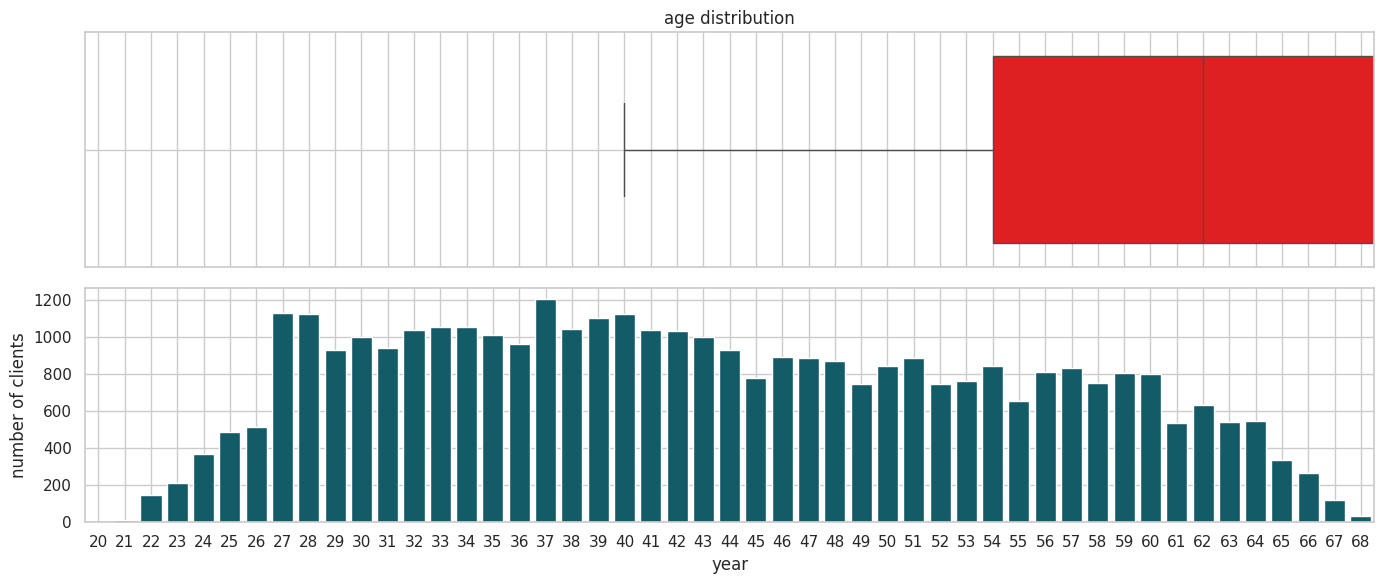

In [51]:
fig, place = plt.subplots(nrows = 2, ncols=1, figsize=(14,6), sharex=True)

sb.boxplot(data = df, x= 'age', ax=place[0], color = 'red')
place[0].set_title('age distribution')
place[0].grid(True)

sb.countplot(data = df, x = 'age', ax = place[1], color = '#066576')
place[1].set_xlabel('year', loc = 'center')
place[1].set_ylabel('number of clients', loc = 'center')
place[1].grid(True)

plt.tight_layout()
plt.show()

Переод возраста в категорию:

In [52]:
df['age'] = df['age'].apply(age_category)
df['age'].value_counts().sort_index()

,count
age,
30-40,10436
40-50,9312
50-60,7952
более чем 60,3829
до 30,4928


Общий доход

In [53]:
df['income_total'] = df["income_total"]/1000

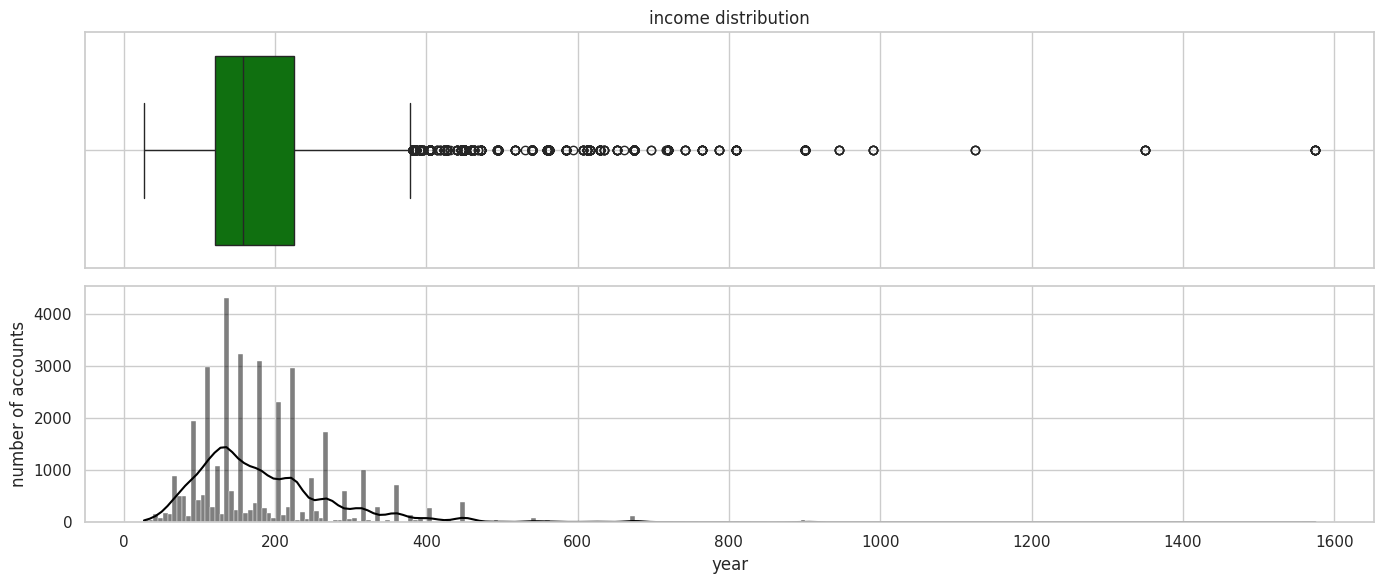

In [54]:
fig, place = plt.subplots(nrows = 2, ncols=1, figsize=(14,6), sharex=True)

sb.boxplot(data = df, x= 'income_total', ax=place[0], color = 'green')
place[0].set_title('income distribution')
place[0].grid(True)

sb.histplot(data = df, x = 'income_total', kde = True, ax = place[1], color = 'black')
place[1].set_xlabel('year', loc = 'center')
place[1].set_ylabel('number of accounts', loc = 'center')
place[1].grid(True)

plt.tight_layout()
plt.show()

База данных содержит большое количество выбросов, мы разделим данные в соответствии с квантилями от 1 до 10

In [55]:
labels = np.arange(1,11)
df['income_total'] = pd.qcut(df['income_total'], q = 10, labels = labels)
df['income_total'] = df['income_total'].apply(lambda x: str(x)+'_quantile')
df['income_total'].value_counts()

,count
income_total,
3_quantile,5871
1_quantile,4479
8_quantile,4139
2_quantile,4123
5_quantile,3957
9_quantile,3903
6_quantile,3897
7_quantile,3253
10_quantile,2702


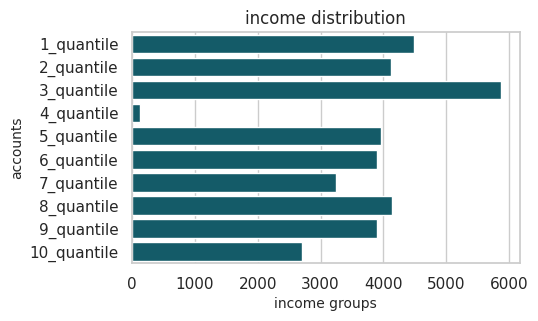

In [56]:
plt.figure(figsize = (5,3))
plt.title('income distribution')
sb.countplot(data = df, y = df['income_total'], color = '#066576')
plt.xlabel('income groups', loc = 'center', fontsize=10)
plt.ylabel('accounts', loc = 'center', fontsize=10)
plt.show()


Тип дохода (работы)

In [57]:
df['type'].unique()

array([nan, 'Security staff', 'Sales staff', 'Accountants', 'Laborers',
       'Managers', 'Drivers', 'Core staff', 'High skill tech staff',
       'Cleaning staff', 'Private service staff', 'Cooking staff',
       'Low-skill Laborers', 'Medicine staff', 'Secretaries',
       'Waiters/barmen staff', 'HR staff', 'Realty agents', 'IT staff'],
      dtype=object)

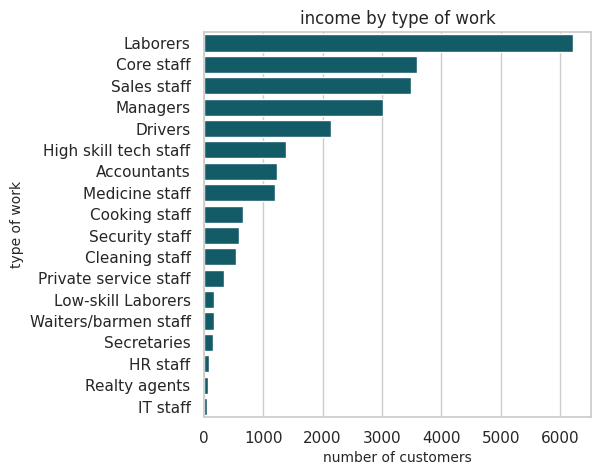

In [58]:
plt.figure(figsize = (5,5))
plt.title('income by type of work')
sb.countplot(data = df, y = 'type', order = df['type'].value_counts().index, color = '#066576')
plt.xlabel('number of customers', loc = 'center', fontsize=10)
plt.ylabel('type of work', loc = 'center', fontsize=10)
plt.show()

In [59]:
df['type'].value_counts(ascending = False)

,count
type,
Laborers,6211
Core staff,3591
Sales staff,3485
Managers,3012
Drivers,2138
High skill tech staff,1383
Accountants,1241
Medicine staff,1207
Cooking staff,655


Разделим на 3 категории

In [60]:
df['type'] = df.loc[:,'type'].apply(work)

In [61]:
df['type'].value_counts()

,count
type,
Неизвестно,11323
Офис,10730
Услуги,8018
Рабочие,6386


In [62]:
df['type'].isna().sum()

0

Заполнение пропущенных значений по типу групп: 'education_type', 'income_total'

In [63]:
df_mode = df.groupby(['education_type', 'income_total'])['type'].agg(pd.Series.mode).reset_index()
df = pd.merge(df, df_mode, right_on = ['education_type', 'income_total'], left_on = ['education_type', 'income_total'], how = 'left')
df['type_x'] = df['type_x'].fillna(df['type_y'])

<ipython-input-63-6e6f6747934a>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_mode = df.groupby(['education_type', 'income_total'])['type'].agg(pd.Series.mode).reset_index()


В столбцах Working on Mobile, Phone, Work phone, Email заменим наличе значений на "Есть", а отсутствие на "Нет", поскольку сами данные о телефоне email и прочее для модели не важны.

In [64]:
columns = ['mobil', 'phone', 'work_phone', 'email']
for column in columns:
    df[column] = df[column].apply(lambda x: "Есть" if x == 1 else "Нет")

Удаление ненужных столбцов для дальнейшего анализа

In [65]:
df.drop(columns = ['id', 'employed', 'type_y', 'birth'], inplace = True)
df.rename(columns = {'type_x': "job_type"}, inplace = True)

Итоговый вид данных:

In [66]:
df.head(3)

,seniority,account_status,gender,own_car,own_realty,children,income_total,income_type,education_type,family_status,housing_type,mobil,work_phone,phone,email,job_type,fam_members,time_employed,age
0,2,0,M,Y,Y,Отсутствуют,10_quantile,Working,Higher education,Civil marriage,Rented apartment,Есть,Есть,Нет,Нет,Неизвестно,Два,10-15 лет,30-40
1,2,0,M,Y,Y,Отсутствуют,10_quantile,Working,Higher education,Civil marriage,Rented apartment,Есть,Есть,Нет,Нет,Неизвестно,Два,10-15 лет,30-40
2,3,0,M,Y,Y,Отсутствуют,2_quantile,Working,Secondary / secondary special,Married,House / apartment,Есть,Нет,Нет,Нет,Услуги,Два,1-5 лет,50-60


## <font color='#11a642' size='5'> Определить роли для независимых признаков

In [67]:
TARGET = 'account_status'
ID_COL = 'id'

In [68]:
num_features = [col for col in df.select_dtypes(exclude='object').columns if col != id and col !=TARGET]
cat_features  = [col for col in df.select_dtypes(include='object').columns if col != id and col !=TARGET]

## <font color='#11a642' size='5'> Корреляция

<Figure size 300x300 with 0 Axes>

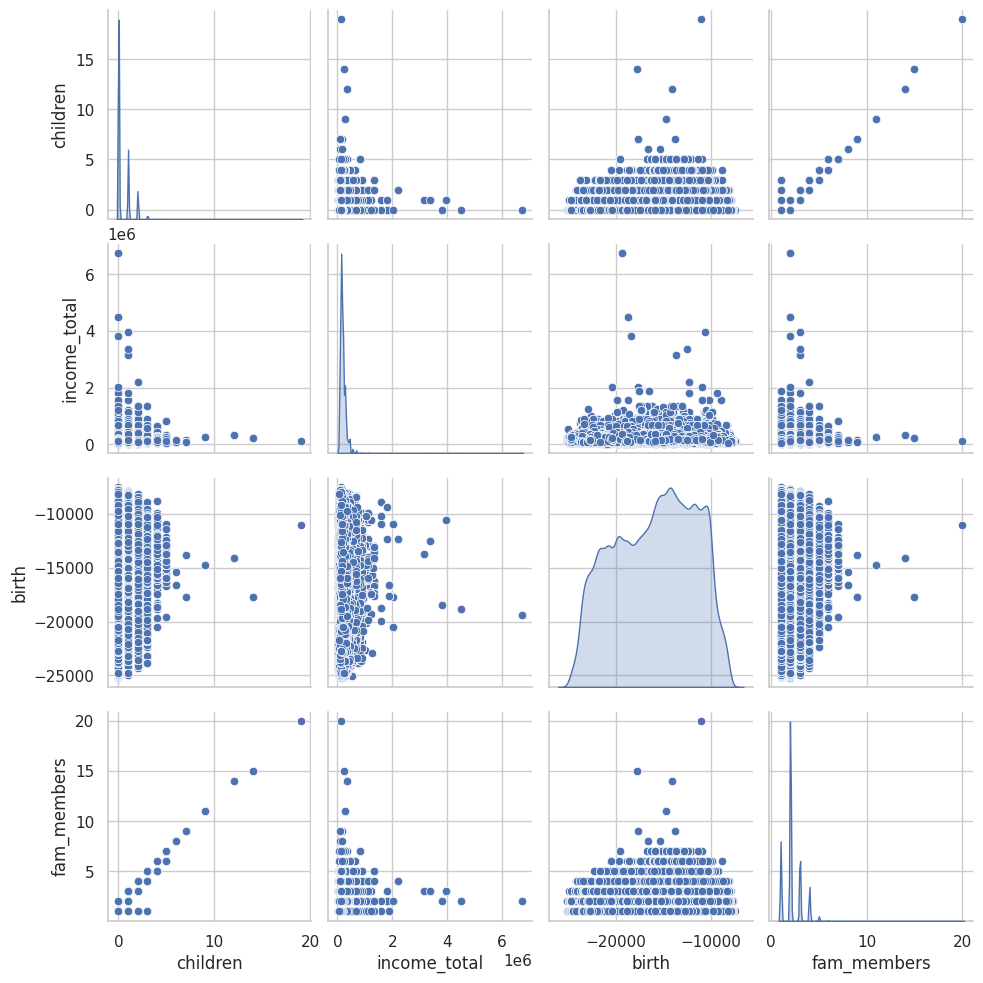

In [69]:
df_pairplot = df_app[['children','income_total', 'birth', 'fam_members']]
plt.figure(figsize=(3, 3))
sb.pairplot(df_pairplot, diag_kind="kde")


Text(0.5, 1.0, 'correlation matrix')

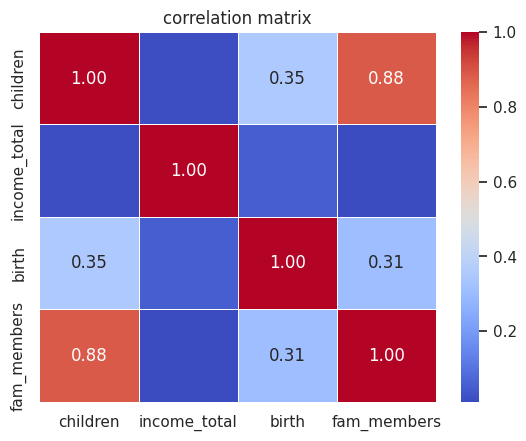

In [70]:
plt.tight_layout()
tmap = sb.heatmap(df_pairplot.corr(), cmap = 'coolwarm', linecolor="white", linewidths=0.5, fmt="0.2f", annot = True)
for t in tmap.texts:
    if float(t.get_text()) >= 0.3 or float(t.get_text()) <= -0.3:
        t.set_text(t.get_text())
    else:
        t.set_text("")
plt.title('correlation matrix', loc = 'center')

<ipython-input-71-aae90e296fd7>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sb.countplot(data = df, x = df[i], palette = "dark")
<ipython-input-71-aae90e296fd7>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sb.countplot(data = df, x = df[i], palette = "dark")
<ipython-input-71-aae90e296fd7>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sb.countplot(data = df, x = df[i], palette = "dark")
<ipython-input-71-aae90e296fd7>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `h

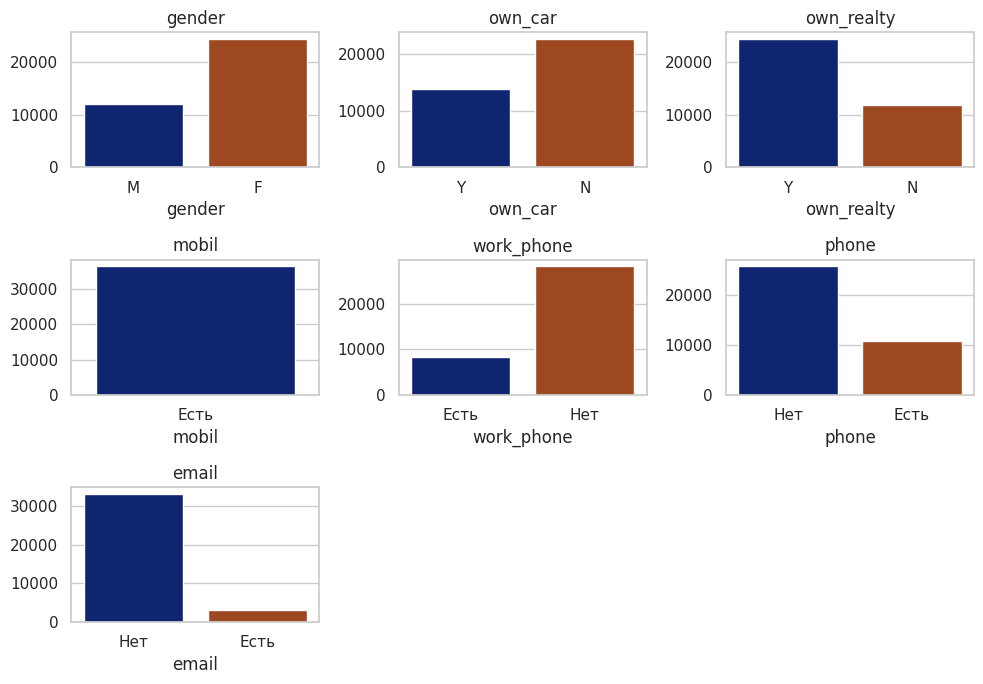

In [71]:
columns = ['gender', 'own_car', 'own_realty', 'mobil', 'work_phone', 'phone', 'email']

plt.figure(figsize=(10, 7))
for i in columns:
    plt.subplot(3, 3, columns.index(i)+1)
    plt.title(i)
    g = sb.countplot(data = df, x = df[i], palette = "dark")
    g.set(ylabel=None)
    g.set(ylabel=None)

plt.tight_layout()
plt.show()

Распределение доходов после разделения на группы

<ipython-input-72-6ee07c295081>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sb.countplot(data = df, y = df['income_total'], order = df['income_total'].value_counts().index, palette = "mako")


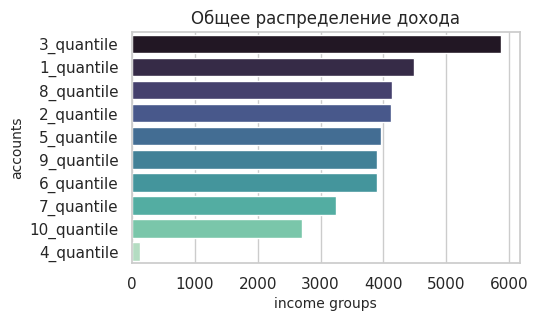

In [72]:
plt.figure(figsize = (5,3))
plt.title('Общее распределение дохода')
sb.countplot(data = df, y = df['income_total'], order = df['income_total'].value_counts().index, palette = "mako")
plt.xlabel('income groups', loc = 'center', fontsize=10)
plt.ylabel('accounts', loc = 'center', fontsize=10)
plt.show()


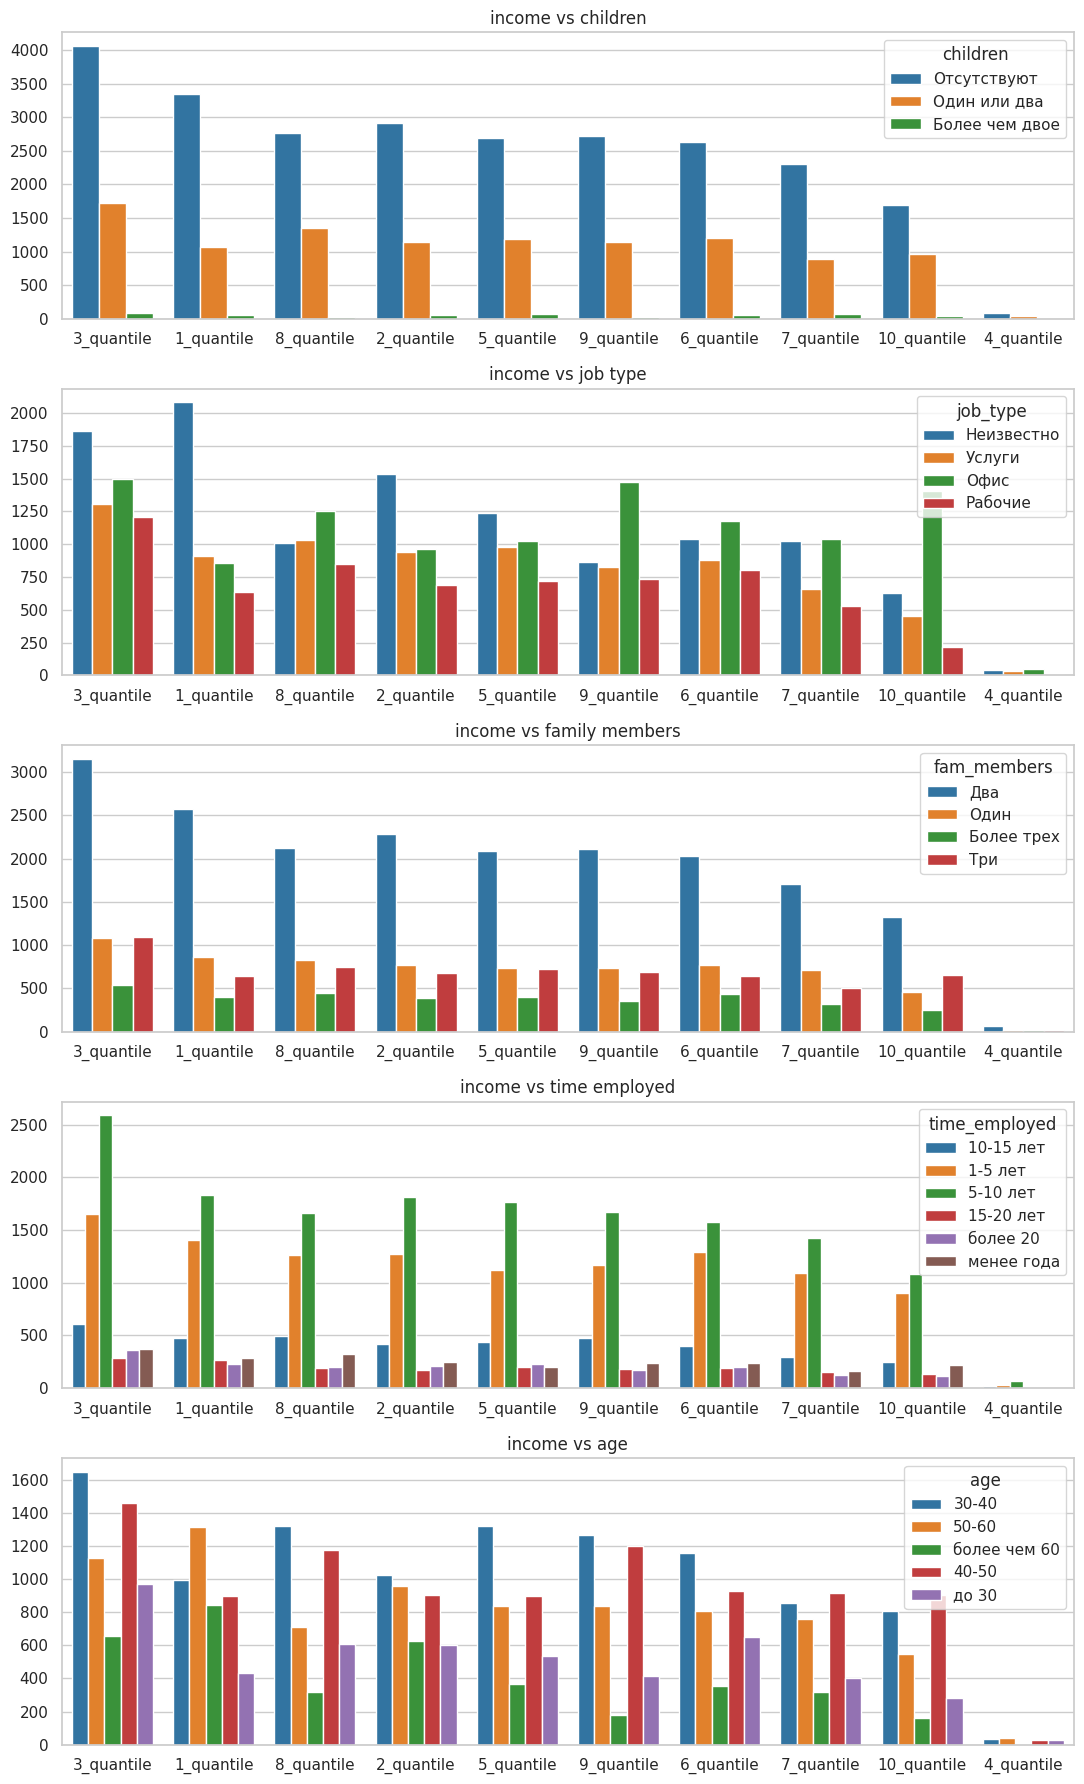

In [73]:
fig, place = plt.subplots(nrows = 5, ncols = 1, figsize = (11,18))

place[0].set_title('income vs children', loc = 'center')
sb.countplot(data = df, x = df['income_total'], order = df['income_total'].value_counts().index, hue = df['children'], palette = "tab10", ax = place[0])
place[0].set_xlabel('')
place[0].set_ylabel('')

place[1].set_title('income vs job type')
sb.countplot(data = df, x = df['income_total'], order = df['income_total'].value_counts().index, hue = df['job_type'], palette = "tab10", ax = place[1])
place[1].set_xlabel('')
place[1].set_ylabel('')

place[2].set_title('income vs family members')
sb.countplot(data = df, x = df['income_total'], order = df['income_total'].value_counts().index, hue = df['fam_members'], palette = "tab10", ax = place[2])
place[2].set_xlabel('')
place[2].set_ylabel('')

place[3].set_title('income vs time employed')
sb.countplot(data = df, x = df['income_total'], order = df['income_total'].value_counts().index, hue = df['time_employed'], palette = "tab10", ax = place[3])
place[3].set_xlabel('')
place[3].set_ylabel('')

place[4].set_title('income vs age')
sb.countplot(data = df, x = df['income_total'], order = df['income_total'].value_counts().index, hue = df['age'], palette = "tab10", ax = place[4])
place[4].set_xlabel('')
place[4].set_ylabel('')

plt.tight_layout()
plt.show()

Распределение по старшинству после разделения на группы

<ipython-input-74-c3d00997991a>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sb.countplot(data = df, y = df['seniority'], order = df['seniority'].value_counts().index, palette = "mako")


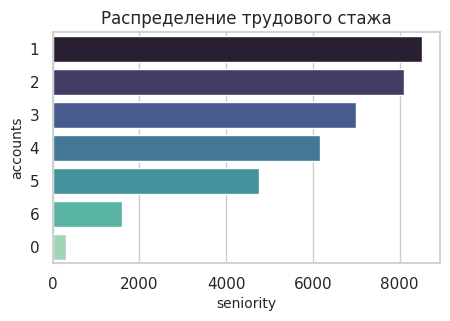

In [74]:
plt.figure(figsize = (5,3))
plt.title('Распределение трудового стажа')
sb.countplot(data = df, y = df['seniority'], order = df['seniority'].value_counts().index, palette = "mako")
plt.xlabel('seniority', loc = 'center', fontsize=10)
plt.ylabel('accounts', loc = 'center', fontsize=10)
plt.show()


Трудовой стаж в разбивке по количеству детей и возрасту

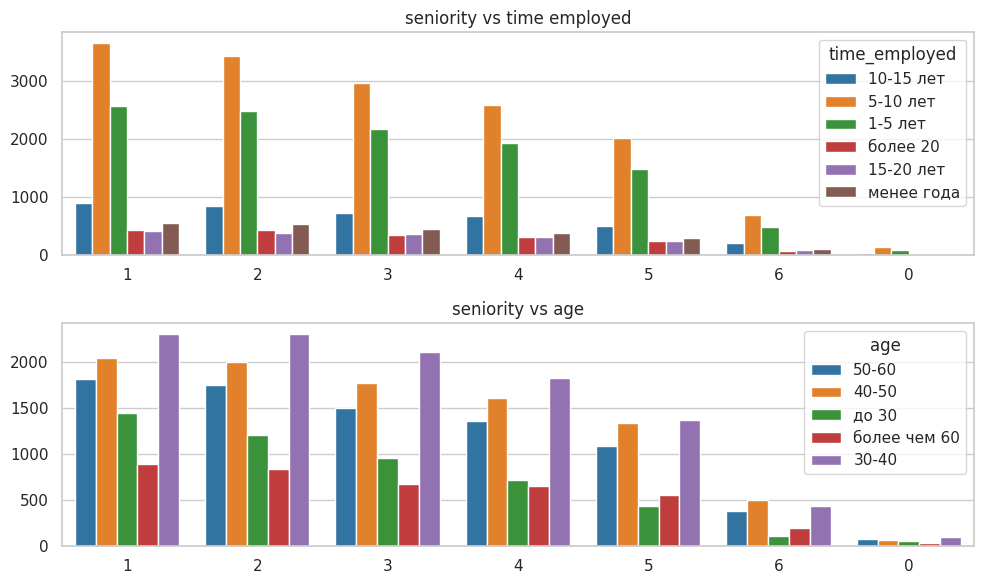

In [75]:
fig, place = plt.subplots(nrows = 2, ncols = 1, figsize = (10,6))#,  sharex=True)

place[0].set_title('seniority vs time employed', loc = 'center')
sb.countplot(data = df, x = df['seniority'], order = df['seniority'].value_counts().index, hue = df['time_employed'], palette = "tab10", ax = place[0])
place[0].set_xlabel('')
place[0].set_ylabel('')

place[1].set_title('seniority vs age')
sb.countplot(data = df, x = df['seniority'], order = df['seniority'].value_counts().index, hue = df['age'], palette = "tab10", ax = place[1])
place[1].set_xlabel('')
place[1].set_ylabel('')

plt.tight_layout()
plt.show()

Распределение типов жилья после разделения на группы

<ipython-input-76-14aae8c537da>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sb.countplot(data = df, y = df['housing_type'], order = df['housing_type'].value_counts().index, palette = "mako")


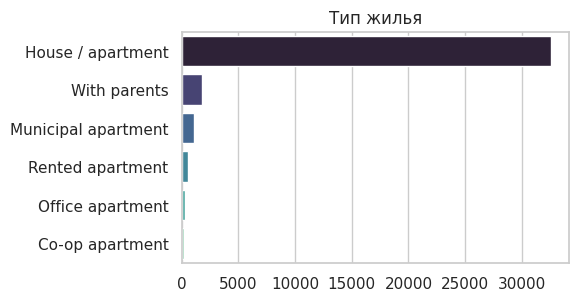

In [76]:
plt.figure(figsize = (5,3))
plt.title('Тип жилья')
sb.countplot(data = df, y = df['housing_type'], order = df['housing_type'].value_counts().index, palette = "mako")
plt.xlabel('')
plt.ylabel('')
plt.show()

Тип жилья в разбивке по детям, возрасту, семейному положению

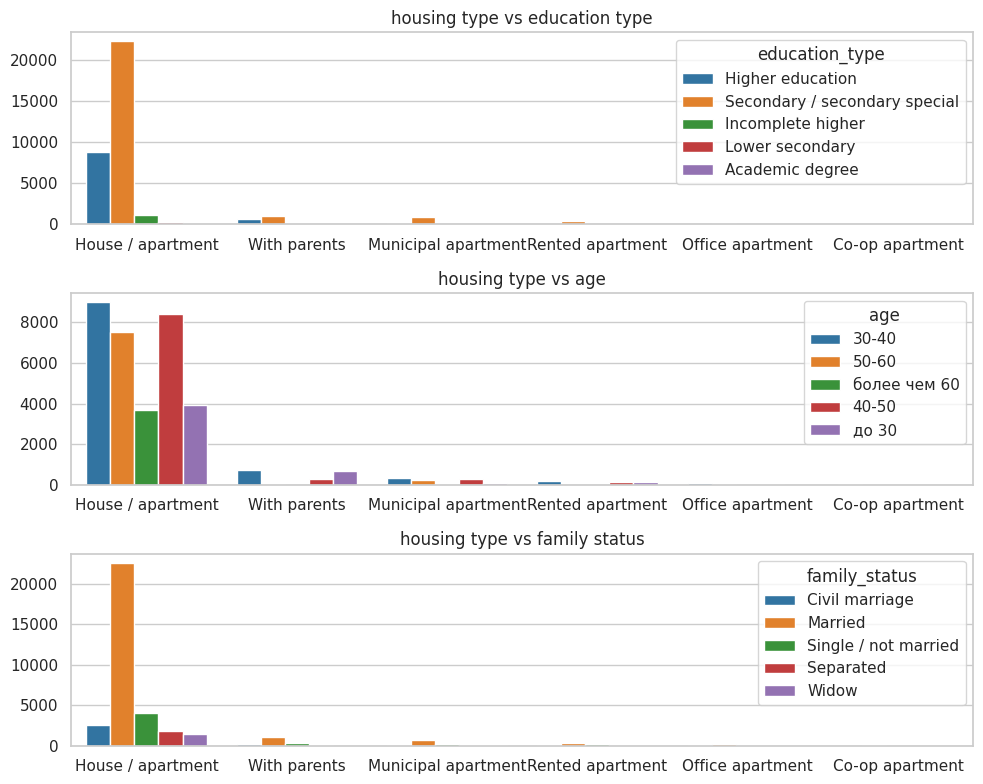

In [77]:
fig, place = plt.subplots(nrows = 3, ncols = 1, figsize = (10,8))#,  sharex=True)

place[0].set_title('housing type vs education type', loc = 'center')
sb.countplot(data = df, x = df['housing_type'], order = df['housing_type'].value_counts().index, hue = df['education_type'], palette = "tab10", ax = place[0])
place[0].set_xlabel('')
place[0].set_ylabel('')

place[1].set_title('housing type vs age')
sb.countplot(data = df, x = df['housing_type'], order = df['housing_type'].value_counts().index, hue = df['age'], palette = "tab10", ax = place[1])
place[1].set_xlabel('')
place[1].set_ylabel('')

place[2].set_title('housing type vs family status')
sb.countplot(data = df, x = df['housing_type'], order = df['housing_type'].value_counts().index, hue = df['family_status'], palette = "tab10", ax = place[2])
place[2].set_xlabel('')
place[2].set_ylabel('')

plt.tight_layout()
plt.show()

Распределение затраченного времени после разделения на группы

<ipython-input-78-f2027339489a>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sb.countplot(data = df, y = df['time_employed'], order = df['time_employed'].value_counts().index, palette = "mako")


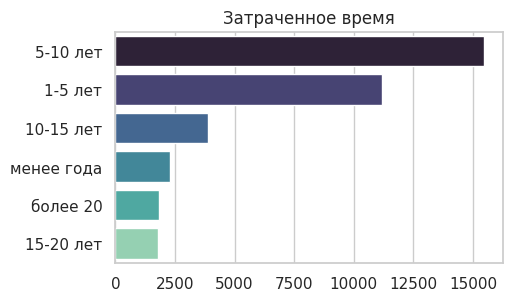

In [78]:
plt.figure(figsize = (5,3))
plt.title('Затраченное время')
sb.countplot(data = df, y = df['time_employed'], order = df['time_employed'].value_counts().index, palette = "mako")
plt.xlabel("")
plt.ylabel("")
plt.show()

Время работы в разбивке по возрасту, типу работы

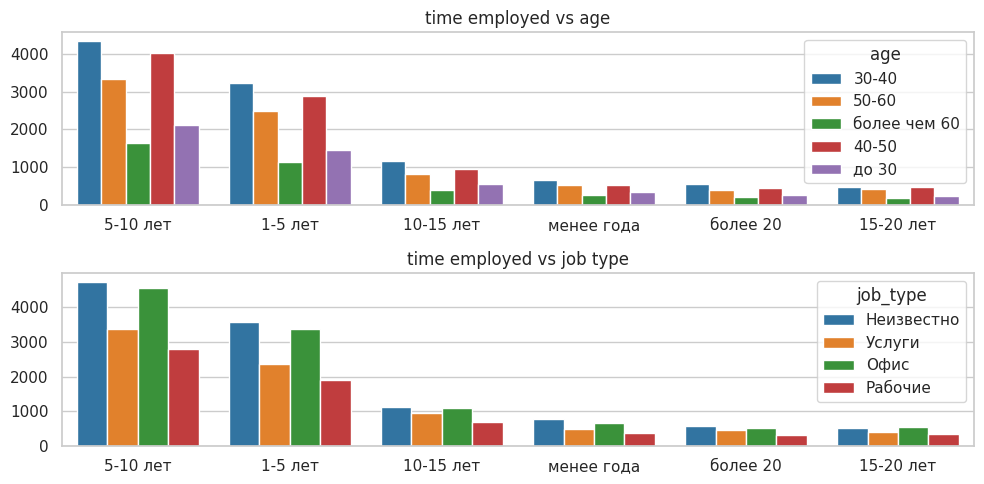

In [79]:
fig, place = plt.subplots(nrows = 2, ncols = 1, figsize = (10,5))#,  sharex=True)

place[0].set_title('time employed vs age', loc = 'center')
sb.countplot(data = df, x = df['time_employed'], order = df['time_employed'].value_counts().index, hue = df['age'], palette = "tab10", ax = place[0])
place[0].set_xlabel('')
place[0].set_ylabel('')

place[1].set_title('time employed vs job type')
sb.countplot(data = df, x = df['time_employed'], order = df['time_employed'].value_counts().index, hue = df['job_type'], palette = "tab10", ax = place[1])
place[1].set_xlabel('')
place[1].set_ylabel('')

plt.tight_layout()
plt.show()

Соотношение категорий

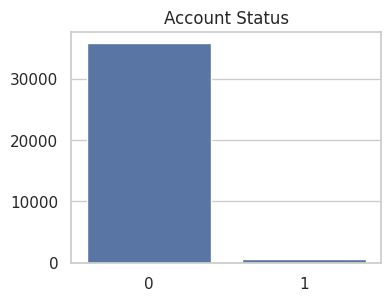

In [80]:
plt.figure(figsize = (4,3))
sb.countplot(x = df['account_status'], data=df)
plt.title('Account Status')
plt.xlabel("")
plt.ylabel("")
plt.show()

Все признаки/столбцы по статусу учетной записи

<ipython-input-81-e7edd90a084f>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sb.countplot(y = df.columns[row], data=df[df['account_status']==col], palette = "dark", ax = place[row, col])
<ipython-input-81-e7edd90a084f>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sb.countplot(y = df.columns[row], data=df[df['account_status']==col], palette = "dark", ax = place[row, col])
<ipython-input-81-e7edd90a084f>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sb.countplot(y = df.columns[row], data=df[df['account_status']==col], palette = "dark", ax = place[row, col])
<ipython-i

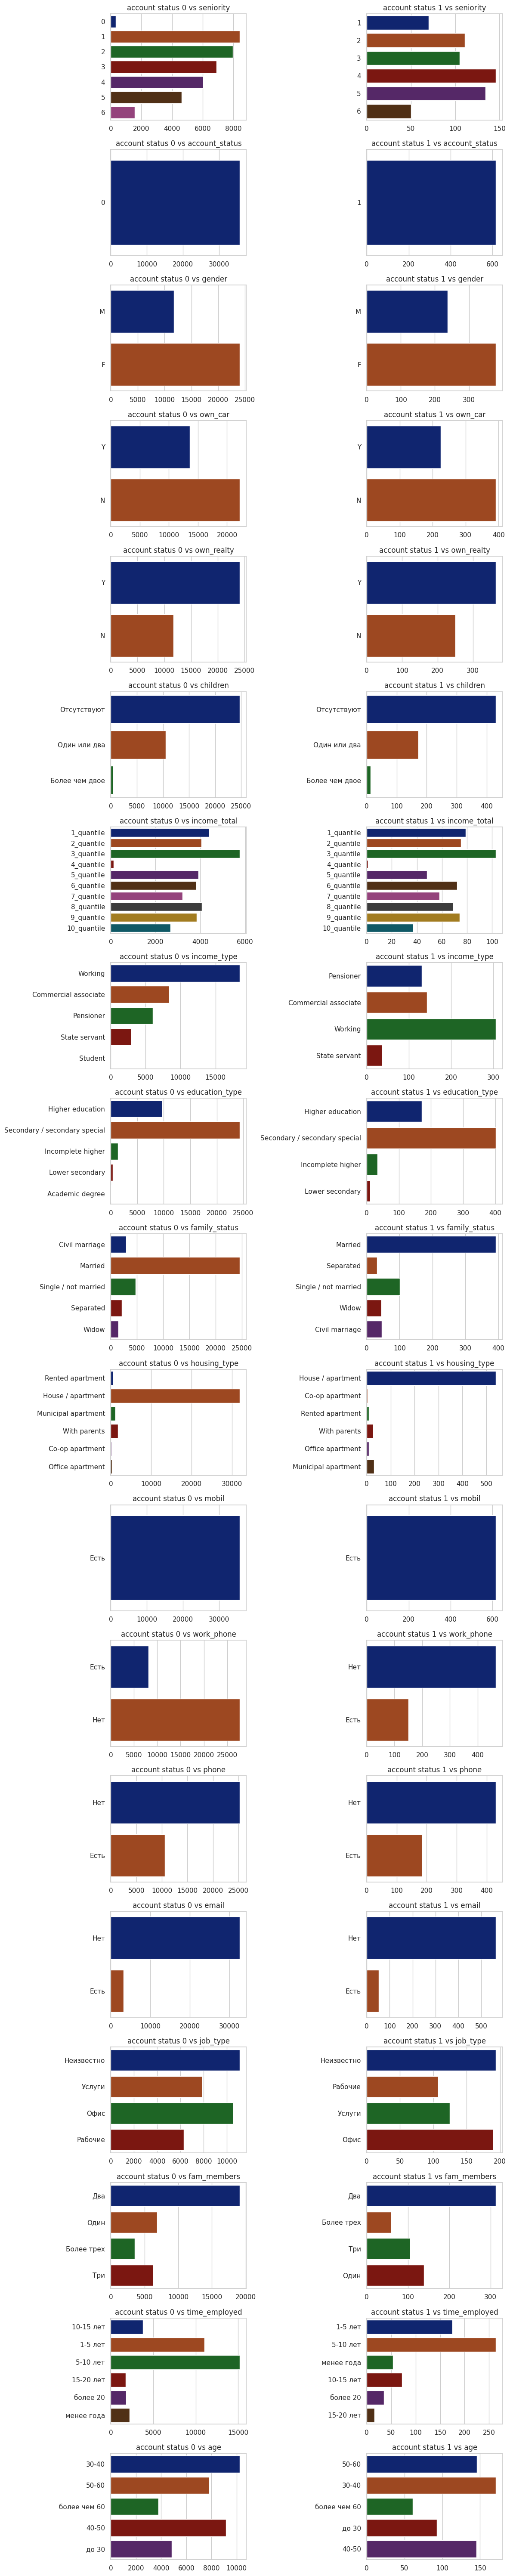

In [81]:
nrows = len(df.columns)
fig, place = plt.subplots(nrows = nrows, ncols = 2, figsize = (12,60))
for row in range(nrows):
    for col in range(2):
        place[row,col].set_title(f'account status {col} vs {df.columns[row]}', loc = 'center')
        sb.countplot(y = df.columns[row], data=df[df['account_status']==col], palette = "dark", ax = place[row, col])
        place[row, col].set_xlabel('')
        place[row, col].set_ylabel('')
plt.tight_layout()
plt.show()

## <font color='#11a642' size='5'> Анализ пропусков


Из всех данных отсутсвут информация только в столбце "Род занятий/профессия".  процент отсутствия велик, но данный параметр не является "предстказуемым" или критически важным, Выше оставили данные значения пустыми. проверим остальные параметры.

In [82]:
df.isnull().sum()

,0
seniority,0
account_status,0
gender,0
own_car,0
own_realty,0
children,0
income_total,0
income_type,0
education_type,0
family_status,0


# <font color='#11a642' size='6'> **Статистические модели**



## <font color='#11a642' size='5'> Подготовка данных для обработки в статистических моделях

In [83]:
X = df.copy()

In [84]:
#Доля групп в данных
X.groupby('account_status')['account_status'].count()/X.shape[0]

,account_status
account_status,
0,0.983103
1,0.016897


In [85]:
y = X['account_status']
X.drop(columns ='account_status', inplace = True)

Мы будем использовать модель только с категориальными данными, поэтому перенесем все данные в str

In [86]:
for column in X.select_dtypes(exclude = 'object').columns:
    X[column] = X[column].astype('str')
print(X.applymap(type).head(2))

       seniority         gender        own_car     own_realty       children  \
0  <class 'str'>  <class 'str'>  <class 'str'>  <class 'str'>  <class 'str'>   
1  <class 'str'>  <class 'str'>  <class 'str'>  <class 'str'>  <class 'str'>   

    income_total    income_type education_type  family_status   housing_type  \
0  <class 'str'>  <class 'str'>  <class 'str'>  <class 'str'>  <class 'str'>   
1  <class 'str'>  <class 'str'>  <class 'str'>  <class 'str'>  <class 'str'>   

           mobil     work_phone          phone          email       job_type  \
0  <class 'str'>  <class 'str'>  <class 'str'>  <class 'str'>  <class 'str'>   
1  <class 'str'>  <class 'str'>  <class 'str'>  <class 'str'>  <class 'str'>   

     fam_members  time_employed            age  
0  <class 'str'>  <class 'str'>  <class 'str'>  
1  <class 'str'>  <class 'str'>  <class 'str'>  


<ipython-input-86-d47799624a69>:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  print(X.applymap(type).head(2))


In [87]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36457 entries, 0 to 36456
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   seniority       36457 non-null  object
 1   gender          36457 non-null  object
 2   own_car         36457 non-null  object
 3   own_realty      36457 non-null  object
 4   children        36457 non-null  object
 5   income_total    36457 non-null  object
 6   income_type     36457 non-null  object
 7   education_type  36457 non-null  object
 8   family_status   36457 non-null  object
 9   housing_type    36457 non-null  object
 10  mobil           36457 non-null  object
 11  work_phone      36457 non-null  object
 12  phone           36457 non-null  object
 13  email           36457 non-null  object
 14  job_type        36457 non-null  object
 15  fam_members     36457 non-null  object
 16  time_employed   36457 non-null  object
 17  age             36457 non-null  object
dtypes: obj

Преобрауем данные в форму доступную для машинного обучения

In [88]:
encoder = OneHotEncoder(sparse_output=False)
X_dum = encoder.fit_transform(X)
X_dum.shape

(36457, 73)

# <font color='#11a642' size='6'> **Построение моделей машинного обучения**

## <font color='#11a642' size='5'> Разделение данных на трейн и тест

In [613]:
X_train, X_test, y_train, y_test = train_test_split(X_dum, y, test_size=0.3, stratify=y, random_state=24)

Группа аккаунтов плохих клиентов значительно меньше, чем группа хороших аккаунтов.

Это может сильно повлиять на результаты моделирования.

Мы будем заполнять данные в группе плохих аккаунтов с помощью SMOTE (только для тренеровочных данных)


In [614]:
smote = SMOTE(random_state = 24)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)
print(f'df shape: {X_train_sm.shape}')

y_train_sm.value_counts(normalize = True)

df shape: (50176, 73)


,proportion
account_status,
0,0.5
1,0.5


## <font color='#11a642' size='5'> Логическая регрессия

In [615]:
model_log = skl.LogisticRegression(random_state = 24)
model_log.fit(X_train_sm, y_train_sm)

LogisticRegression(random_state=24)

In [616]:
y_pred_log = model_log.predict(X_test)
y_prob_log = model_log.predict_proba(X_test)[:, 1]

log_acc = accuracy_score(y_test, y_pred_log)
log_auc = roc_auc_score(y_test, y_prob_log)
print(f'accuracy log: {log_acc:.3f}')
print(f'ROC-AUC log: {log_auc:.3f}')

accuracy log: 0.631
ROC-AUC log: 0.631


In [617]:
confusion_matrix(y_test ,y_pred_log)

array([[6803, 3950],
       [  84,  101]])

In [618]:
cr = classification_report(y_test, y_pred_log)
print(cr)

              precision    recall  f1-score   support

           0       0.99      0.63      0.77     10753
           1       0.02      0.55      0.05       185

    accuracy                           0.63     10938
   macro avg       0.51      0.59      0.41     10938
weighted avg       0.97      0.63      0.76     10938



Уменьшение характеристик

In [619]:
X_fr = X[['seniority', 'own_realty', 'income_type', 'education_type', 'family_status', 'time_employed']]

In [620]:
X_dum_fr = encoder.fit_transform(X_fr)

X_train_fr, X_test_fr, y_train_fr, y_test_fr = train_test_split(X_dum_fr, y, test_size=0.3, shuffle=True, random_state=24)

X_train_fr.shape

(25519, 30)

In [621]:
smote = SMOTE(random_state = 24)
X_train_sm_fr, y_train_sm_fr = smote.fit_resample(X_train_fr, y_train_fr)
print(f'df shape: {X_train_sm_fr.shape}')

y_train_sm_fr.value_counts(normalize = True)

df shape: (50172, 30)


,proportion
account_status,
0,0.5
1,0.5


In [622]:
model_log_fr = skl.LogisticRegression()
model_log_fr.fit(X_train_sm_fr, y_train_sm_fr)

y_pred_log_fr = model_log_fr.predict(X_test_fr)
y_prob_log_fr = model_log_fr.predict_proba(X_test_fr)[:, 1]

cr = classification_report(y_test_fr, y_pred_log_fr)
print(cr)
confusion_matrix(y_test_fr ,y_pred_log_fr)

              precision    recall  f1-score   support

           0       0.99      0.59      0.74     10755
           1       0.02      0.60      0.05       183

    accuracy                           0.59     10938
   macro avg       0.51      0.60      0.39     10938
weighted avg       0.97      0.59      0.73     10938



array([[6337, 4418],
       [  73,  110]])

## <font color='#11a642' size='5'> Построение модели knn



In [623]:
KNN_model = KNeighborsClassifier()

param_togrid = [{'n_neighbors': [3, 5], 'weights': ['uniform', 'distance']}]

grid_search = GridSearchCV(estimator = KNN_model, param_grid = param_togrid, scoring = 'roc_auc', cv = 3, verbose = 0)
grid_search.fit(X_train_sm, y_train_sm)


GridSearchCV(cv=3, estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': [3, 5],
                          'weights': ['uniform', 'distance']}],
             scoring='roc_auc')

In [624]:
#Результат модели
best_model_KNN = grid_search.best_estimator_
best_params_KNN = grid_search.best_params_
best_score_KNN = grid_search.best_score_
y_pred_KNN = best_model_KNN.predict(X_test)
y_proba_KNN = best_model_KNN.predict_proba(X_test)[:,1]
accuracy_test_KNN = accuracy_score(y_test, y_pred_KNN)
roc_auc_KNN = roc_auc_score(y_test, y_proba_KNN)
cr_KNN = classification_report(y_test, y_pred_KNN, output_dict=True)
cm_KNN = confusion_matrix(y_test, y_pred_KNN)

print(f"ROC-AUC KNN: {roc_auc_KNN:.3f}")
print(f'best params KNN: {best_params_KNN}')
print(f'best score KNN: {best_score_KNN:.3f}')
print(f'accuracy test KNN: {accuracy_test_KNN:.3f}')
pd.DataFrame(cr_KNN).transpose()

ROC-AUC KNN: 0.743
best params KNN: {'n_neighbors': 5, 'weights': 'uniform'}
best score KNN: 0.978
accuracy test KNN: 0.905


,precision,recall,f1-score,support
0,0.991300,0.911281,0.949608,10753.000000
1,0.094017,0.535135,0.159935,185.000000
accuracy,0.904919,0.904919,0.904919,0.904919
macro avg,0.542659,0.723208,0.554771,10938.000000
weighted avg,0.976124,0.904919,0.936251,10938.000000


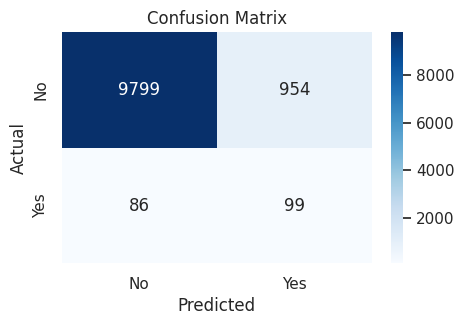

In [625]:
#Матрица лучшей модели
plt.figure(figsize = (5,3))
sb.heatmap(cm_KNN, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

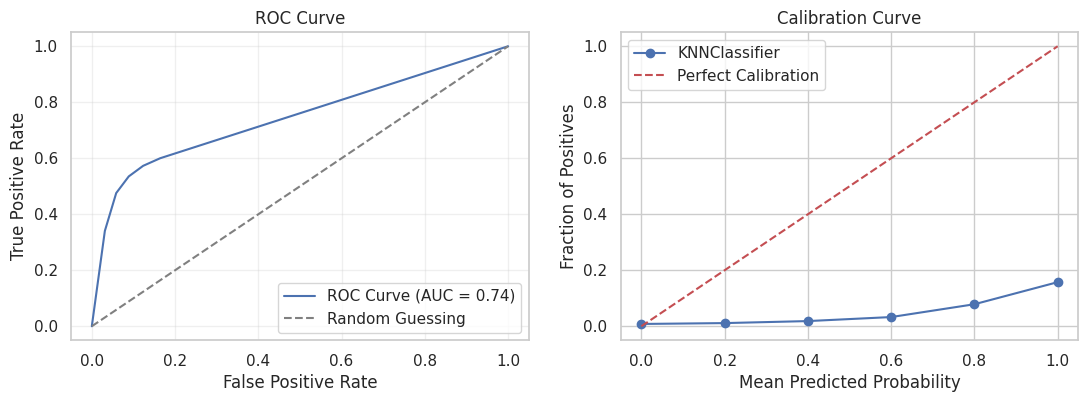

In [626]:
# Исследование полученной модели
plt.figure(figsize = (13,4))

# AUC - ROC

fpr, tpr, thresholds = roc_curve(y_test, y_proba_KNN)

roc_auc = skm.auc(fpr, tpr)
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)

# Калибровочная кривая

prob_true, prob_pred = calibration_curve(y_test, y_proba_KNN, n_bins=10)
plt.subplot(1, 2, 2)
plt.plot(prob_pred, prob_true, marker='o', label='KNNClassifier')
plt.plot([0, 1], [0, 1], 'r--', label='Perfect Calibration')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve')
plt.legend()

plt.show()

## <font color='#11a642' size='5'> SVC

Используем различные гиперпараметры для улучшения результатов регрессии.

Моделируйте SVC

In [627]:
model_SVC = SVC(probability=True, random_state = 24)

param_grid = [{'kernel': ['linear', 'rbf']}]

grid_search = GridSearchCV(estimator = model_SVC, scoring = 'roc_auc', param_grid = param_grid, return_train_score=True, cv = 3, verbose = 0)
grid_search.fit(X_train_sm, y_train_sm)

GridSearchCV(cv=3, estimator=SVC(probability=True, random_state=24),
             param_grid=[{'kernel': ['linear', 'rbf']}],
             return_train_score=True, scoring='roc_auc')

In [628]:
#Результат модели
best_model_SVC = grid_search.best_estimator_
best_params_SVC = grid_search.best_params_
best_score_SVC = grid_search.best_score_
y_pred_SVC = best_model_SVC.predict(X_test)
y_proba_SVC = best_model_SVC.predict_proba(X_test)[:, 1]
accuracy_test_SVC = accuracy_score(y_test, y_pred_SVC)
roc_auc_SVC = roc_auc_score(y_test, y_proba_SVC)
cr_SVC = classification_report(y_test, y_pred_SVC, output_dict=True)
cm_SVC = confusion_matrix(y_test, y_pred_SVC)

print(f"ROC-AUC SVC: {roc_auc_SVC:.3f}")
print(f'best model SVC: {best_model_SVC}')
print(f'best params SVC: {best_params_SVC}')
print(f'best score SVC: {best_score_SVC:.3f}')
print(f'accuracy test SVC: {accuracy_test_SVC:.3f}')
pd.DataFrame(cr_SVC).transpose()

ROC-AUC SVC: 0.784
best model SVC: SVC(probability=True, random_state=24)
best params SVC: {'kernel': 'rbf'}
best score SVC: 0.999
accuracy test SVC: 0.978


,precision,recall,f1-score,support
0,0.986480,0.990700,0.988586,10753.00000
1,0.280576,0.210811,0.240741,185.00000
accuracy,0.977510,0.977510,0.977510,0.97751
macro avg,0.633528,0.600756,0.614663,10938.00000
weighted avg,0.974541,0.977510,0.975937,10938.00000


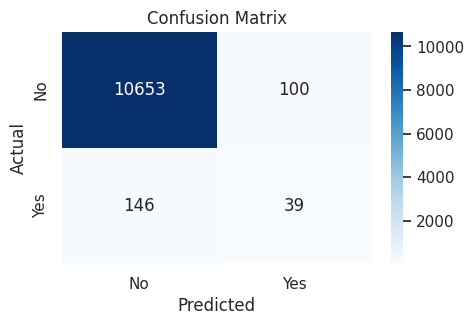

In [629]:
#Матрица лучшей модели
plt.figure(figsize = (5,3))
sb.heatmap(cm_SVC, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## <font color='#11a642' size='5'> CatBoost

In [1]:
CBoost_model = CatBoostClassifier(verbose = 0)

param_togrid = [{'iterations': [100, 250], 'learning_rate': [0.01, 0.1, 0.2], 'l2_leaf_reg': [3, 5],
                 'colsample_bylevel': [0.7, 1.0], 'random_state': [24]}]

grid_search = GridSearchCV(estimator = CBoost_model, param_grid = param_togrid, scoring = 'roc_auc', cv = 3, verbose = 0)
grid_search.fit(X_train_sm, y_train_sm)

NameError: name 'CatBoostClassifier' is not defined